# Computing Reduced Density Matrices from MPO

### Basics Imports

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    #level=logging.INFO
    level=logging.DEBUG
)
logger = logging.getLogger('__name__')

In [ ]:
import numpy as np
import pandas as pd
import sys

### TensorNetworks imports

In [ ]:
sys.path.append("../")
import tensornetworks as tn
import tn_quantum_circuits as tnqc
import gates as gt
from tensornetworks import contract_indices, contract_indices_one_tensor

### Imports QLM

In [ ]:
import qat.lang.AQASM as qlm
from qat.qpus import PyLinalg
qpu_p = PyLinalg()
from qlm_stuff import proccess_qresults

## 1. Functions for creating the MPS

In [ ]:
def apply_2qubit_gates(qubits, gates):
    """
    Executes product of tensor with a gate
    -o-o-o-o-o-..o-o-
     |   |   |     |
    """
    new_qubits = [0 for i in qubits]
    left = qubits[0]
    for i in range(1, len(qubits)):
        right = qubits[i]
        gate = gates[i-1]
        #new_qubits[i-1], left = phase_change(left, right, gate)
        new_qubits[i-1], left = tnqc.apply_2qubit_gate(left, right, gate)

    new_qubits[-1], new_qubits[0] = tnqc.apply_2qubit_gate(
        left, new_qubits[0], gates[-1])
     #new_qubits[-1], new_qubits[0] = phase_change(left, new_qubits[0], gates[-1])
    return new_qubits

In [ ]:
def get_angles(depth):
    theta = np.pi/4.0
    delta_theta = theta / (depth + 1)
    angles = []
    for i in range(depth):
        angles.append([(2 * i + 1) * delta_theta, (2 * i + 2) * delta_theta])
    return angles     

In [ ]:
def ansatz(nqubits, depth, angles):
    # Intitial State
    zeroket = np.zeros((1, 2, 1))
    zeroket[0][0][0] = 1
    zeroket = zeroket.astype(complex)
    #Initial State
    mps_ = [zeroket] * nqubits
    for depth_ in range(depth):
        # First Layer
        gates = [gt.x_rotation(angles[depth_][0]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
        ent_gates = [gt.controlz() for i in mps_]
        mps_ = apply_2qubit_gates(mps_, ent_gates)
        gates = [gt.z_rotation(angles[depth_][1]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
    return mps_

In [ ]:
def ansatz_qlm(nqubits, depth, angles):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for d_ in range(0, depth):
        for i in range(nqubits):
            qprog.apply(qlm.RX(angles[d_][0]), qbits[i])
        for i in range(nqubits-1):
            qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
        qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
        for i in range(nqubits):
            qprog.apply(qlm.RZ(angles[d_][1]), qbits[i])    
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ  

## 2. Creating MPS

In [ ]:
# MPS uisng My code
depth = 1
nqubits = 4
mps = ansatz(nqubits, depth, get_angles(depth))

In [ ]:
# State of MPS
pdf_zalo = tnqc.get_state_from_mps(mps)

In [ ]:
#Stat of circuit for comparing with MPS computations
pdf, c= ansatz_qlm(nqubits, depth,  get_angles(depth))

In [ ]:
%qatdisplay c --svg

In [ ]:
# Testing if state from MPS is equat to state from QLM circuit
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

In [ ]:
[mps_.shape for mps_ in mps]

## 2. Computing density matrix

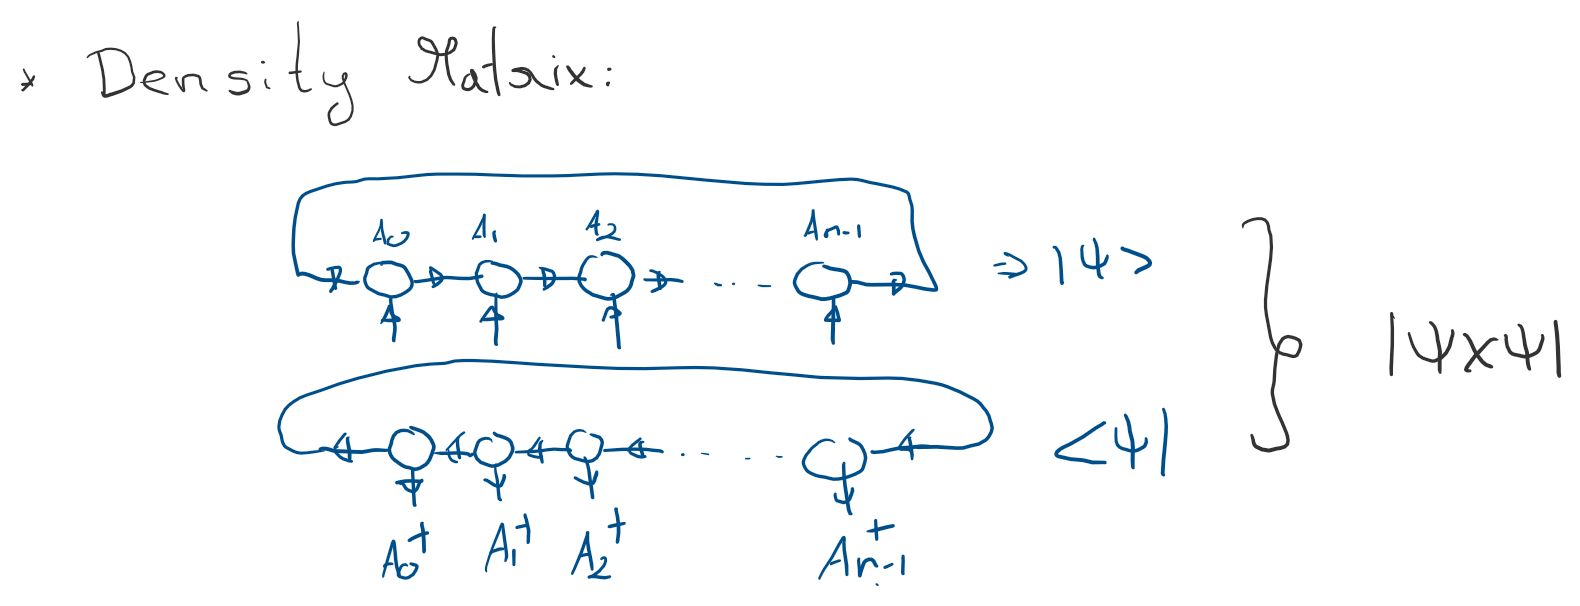

In [ ]:
[mps_.shape for mps_ in mps]

In [ ]:
# Naive Computation of density matrix: |Phi><Psi|
amp = np.array(pdf_zalo["Amplitude"])
amp = amp.reshape(amp.shape[0], 1)
rho0 = amp @ amp.conj().T

In [ ]:
# Computing Density Matrix using reduced_matrix for pure tensors
amp = np.array(pdf_zalo["Amplitude"])
amp = amp.reshape(tuple([2 for i in range(nqubits)]))
rho1 = tn.reduced_matrix(amp, [0, 1, 2, 3], [])

In [ ]:
#Testing both computations are equivalent
np.isclose(rho0, rho1).all()

## 3. Reduced Density Matrix from Matrix Multiplication

In this case we use matrix multiplication by extracting the matrix from the MPS sites that are not going to be contracted. It has lower RAM consumption but It takes a lot of time. 

### How does it work?

For the non contrracted sites all possible matrices should be extracted and combined for getting each one of the elements of the reduced density matrix

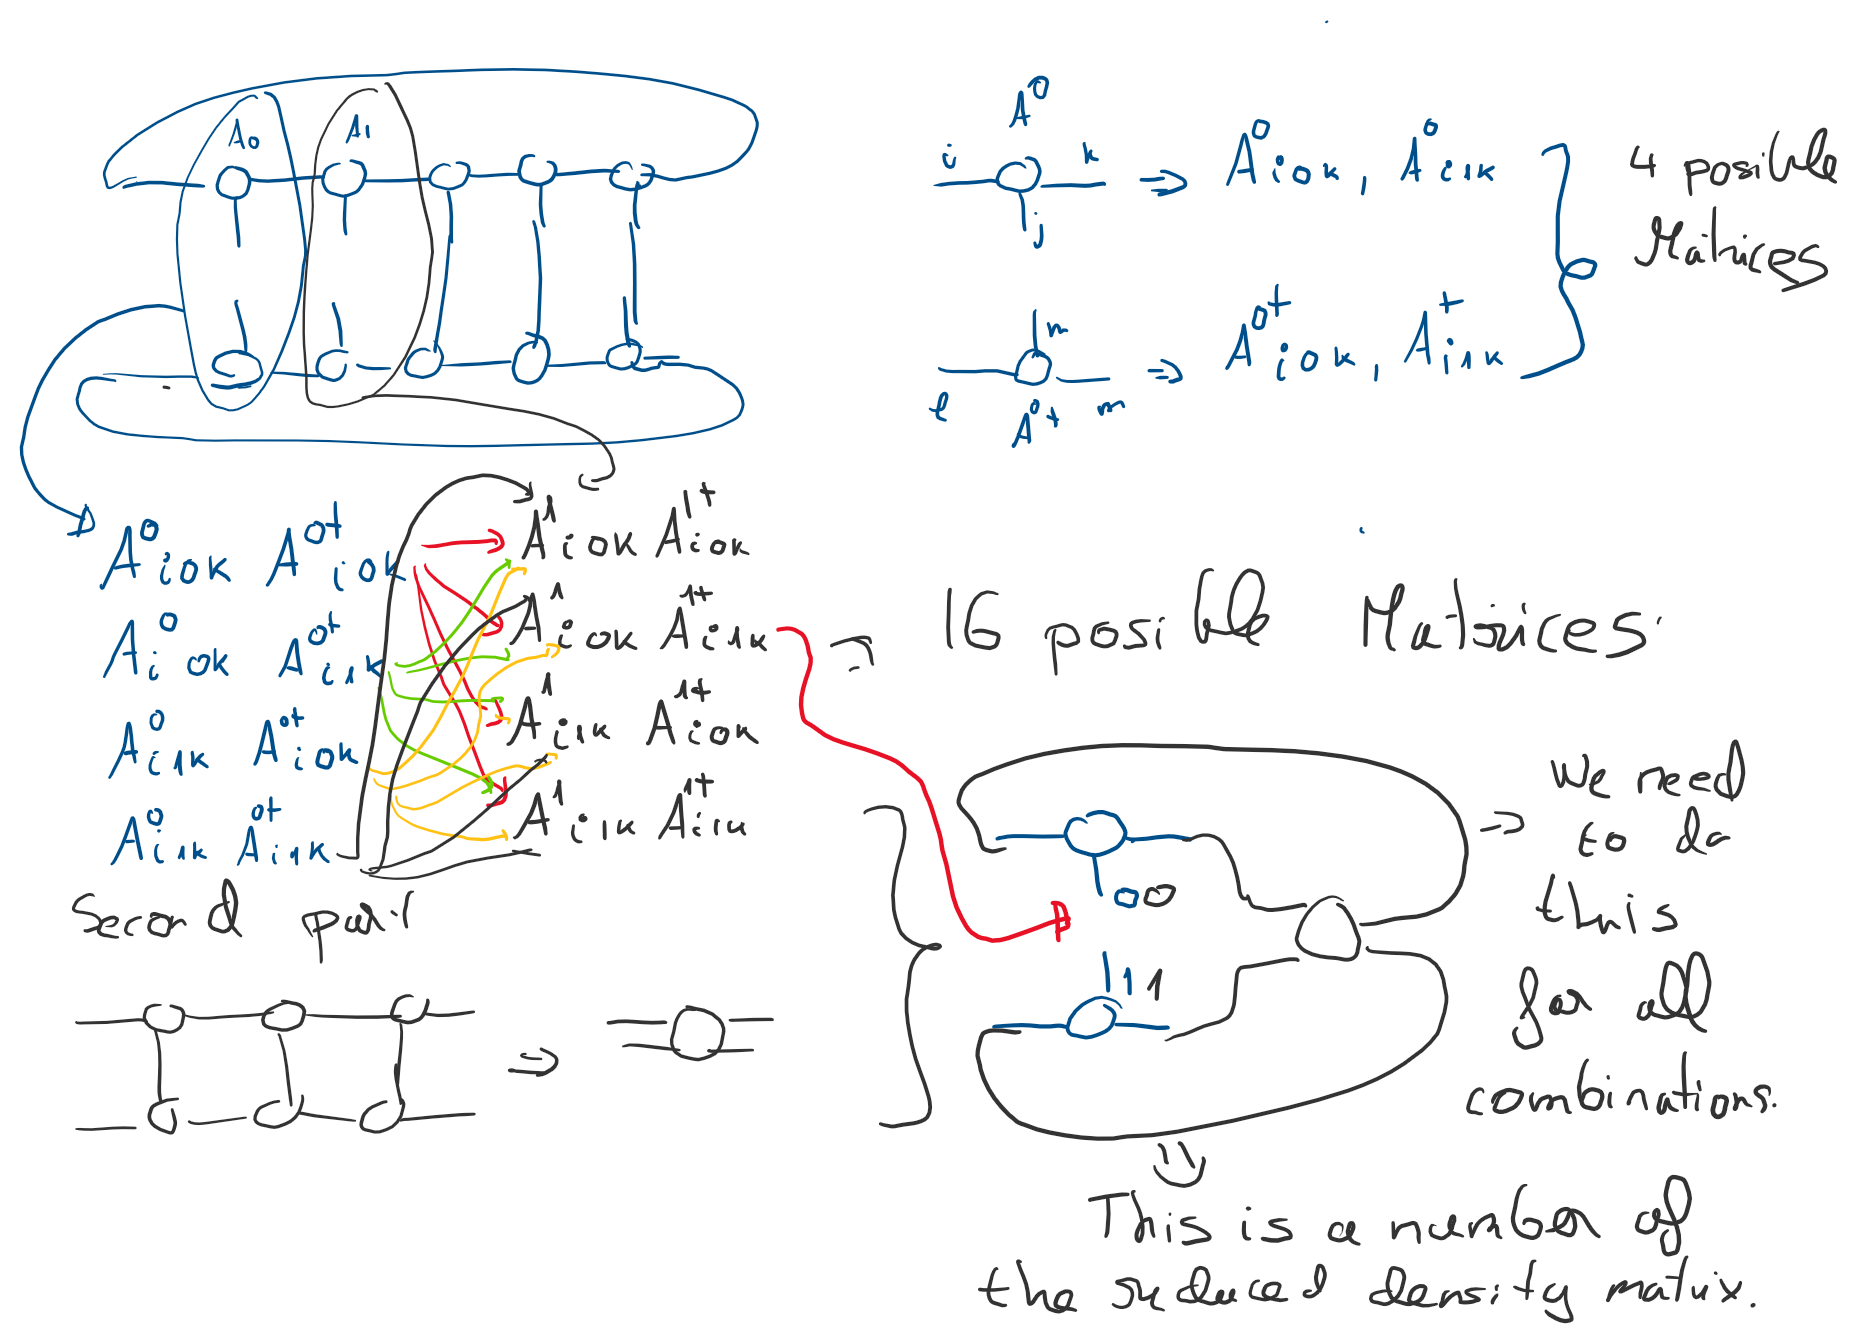

In [ ]:
from reduced_rho import reduced_rho_mpo_fulllist

In [ ]:
free = [0]
contraction = [1, 2, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mpo_fulllist(mps, free, contraction)
).all()

In [ ]:
free = [0, 1]
contraction = [2, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mpo_fulllist(mps, free, contraction)
).all()

In [ ]:
free = [0, 1, 2]
contraction = [3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mpo_fulllist(mps, free, contraction)
).all()

In [ ]:
free = [0, 2]
contraction = [1, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mpo_fulllist(mps, free, contraction)
).all()

In [ ]:
free = [0, 3]
contraction = [1, 2]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mpo_fulllist(mps, free, contraction)
).all()